In [1]:
import numpy as np
from scipy.optimize import linprog
from pymprog import *
import networkx as nx
import matplotlib
import sympy as sy
%matplotlib inline

# Utility Functions
The functions in this section are used throughout this notebook.
- **draw_graph(G)**  
  This function uses networkx package to draw the graph. The graph input is a dictionary of sets e.g. G = {1:{2}, 2:{1}}
- **subsets(V, prefix, arr_sets)**  
  This function creates all the possible subsets for the vertices of a graph. It takes a list of vertices and returns the generated sets in arr_sets list. 
- **subsets_dict(V, prefix, arr_sets)**   
  This function creates all the possible subsets as keys with the subset expected position in the solution vector as the value for the vertices of a graph. It takes a list of vertices and returns the generated sets and their positions in arr_sets dictionary.
- **remove_unconnected_v(graph)**  
  This function takes a graph and returns the graph with all vertices that have at least one neighbour 
- **remove_duplicate_A(A=np.array([]))**  
  This function removes all duplicated rows from matrix A as a result of modifing the constraints 

In [2]:
def draw_graph(G):
    nx_G = nx.from_dict_of_lists(G)
    nx.draw_networkx(nx_G)

In [3]:
def subsets(V, prefix=[], arr_sets=[]):
    if V == []: return
    for i in range(len(V)):
        subset = prefix + [V[i]]
        arr_sets += [subset]
        subsets(V[i+1:], subset, arr_sets)

In [4]:
def subsets_dict(V, prefix=[], arr_sets={}):
    if V == []: return 1
    for i in range(len(V)):
        subset = prefix + [V[i]]
        arr_sets[tuple(subset)] = len(arr_sets)
        subsets_dict(V[i+1:], subset, arr_sets)

In [5]:
def remove_unconnected_v(graph):
    keys = list(graph.keys())
    for v in keys:
        if len(graph[v]) == 0:
            graph.pop(v, None)

In [6]:
def remove_duplicate_A(A=np.array([])):
    temp_a = np.ascontiguousarray(A)
    unique_a = np.unique(temp_a.view([('', temp_a.dtype)]*temp_a.shape[1]))
    A = unique_a.view(temp_a.dtype).reshape((unique_a.shape[0], temp_a.shape[1]))
    return A

# Linear Program for fractional clique number

This function checks if a certain subset is a clique of a graph $G=(V,E)$ i.e. the subset $K$ satisfy the condition that for any distict $u,v \in K$, $uv \in E$

In [7]:
def check_clique(graph, v_set):
    if len(v_set) < 2: return True
    for i in range(len(v_set)):
        i_set = set(v_set[:i] + v_set[i+1:])
        g_set = graph[v_set[i]]
        if i_set & g_set != i_set :
            return False
    return True

In [8]:
def A_clique_set(graph, v_encode, subsets, A=[], cliques=[]):
    for subset in subsets:
        if check_clique(graph, subset):
            cliques += [tuple(subset)]
            A += [sum([v_encode[v] for v in subset])]

In [9]:
def lp_clique(graph, rational=True):
    V = list(graph.keys())
    v_encode = {}
    v_num = len(V)
    
    for i in range(v_num):
        temp = np.zeros(v_num)
        temp[i] = -1
        v_encode[V[i]] = temp
    
    arr_sets = []
    subsets(V, arr_sets=arr_sets)
    
    b_clique = np.negative(np.ones(v_num))
    A_clique = []
    cliques = []
    A_clique_set(graph, v_encode, arr_sets,A=A_clique, cliques=cliques)
    A_clique = np.transpose(np.array(A_clique))
    c_clique = np.ones(A_clique.shape[1])
    
    res = linprog(c_clique, A_ub=A_clique, b_ub=b_clique, bounds=(0, None))
    
    x_rational = list(map(lambda x : sy.nsimplify(x, tolerance=0.01), res.x))
    
    x_cliques = {}
    for i in range(len(x_rational)):
        x_cliques[cliques[i]] = x_rational[i]
    
    return sy.nsimplify(res.fun, tolerance=0.01), x_rational, x_cliques

# Linear Program for Shannon entropy

In [10]:
def entropy_eq_dict(graph, eq_dict={}):
    for v in graph:
        n = tuple(sorted(list(graph[v])))
        n_v = tuple(sorted(list(graph[v] | {v})))
        if n in eq_dict:
            eq_dict[n_v] = eq_dict[n]
        else:
            eq_dict[n] = n_v    

## using scipy

In [11]:
def A_entropy_eq_set(subsets_dict, eq_dict, A=[]):
    num_sets = len(subsets_dict)
    for k in eq_dict:
        v = eq_dict[k]
        a_eq = np.zeros(num_sets)
        a_eq[subsets_dict[k]] = 1
        a_eq[subsets_dict[v]] = -1
        A += [a_eq]

In [12]:
def A_entropy_set(graph, subsets_dict, eq_dict,  A=[]):
    num_sets = len(subsets_dict)
    subsets = list(subsets_dict.keys())
    for i in range(num_sets):
        subset_i = subsets[i]
        pos_i = subsets_dict[subset_i]
        rep_i = subset_i in eq_dict
        for j in range(i + 1, num_sets):
            subset_j = subsets[j]
            pos_j = subsets_dict[subset_j]
            rep_j = subset_j in eq_dict            
            
            val_i, val_j = (), ()
            
            if rep_i:
                pos_i = subsets_dict[eq_dict[subset_i]]
            if rep_j:
                pos_j = subsets_dict[eq_dict[subset_j]]

            subset_i_s = set(subset_i)
            subset_j_s = set(subset_j)
            subset_ij_u = tuple(subset_i_s | subset_j_s)
            subset_ij_i = tuple(subset_i_s & subset_j_s)
            
            pos_u = subsets_dict[subset_ij_u]
            
            if subset_ij_u in eq_dict:
                pos_u = subsets_dict[eq_dict[subset_ij_u]]
            
            if (subset_ij_i == subset_i or subset_ij_i == subset_j):
                if pos_i == pos_j: 
                    continue
                diff = len(subset_i) - len(subset_j)
                a_mq = np.zeros(num_sets) 
                if diff == 1:
                    a_mq[pos_i] = -1
                    a_mq[pos_j] = 1
                    A += [a_mq]
                elif diff == -1:
                    a_mq[pos_i] = 1
                    a_mq[pos_j] = -1
                    A += [a_mq]
            else:
                if ((pos_i == pos_u and pos_j != pos_u) or 
                (pos_j == pos_u and pos_i != pos_u)): 
                    continue
                a_lq = np.zeros(num_sets) 
                
                a_lq[pos_i] = -1
                a_lq[pos_j] = -1
                
                if pos_i == pos_j == pos_u:
                    continue
                    a_lq[pos_u] = -1
                else:
                    a_lq[pos_u] = 1
                
                if len(subset_ij_i) > 0:
                    if subset_ij_i in eq_dict:
                        pos_ij = subsets_dict[eq_dict[subset_ij_i]]
                        if pos_i != pos_j:
                            if pos_i == pos_ij:
                                a_lq[pos_i] = 0
                            elif pos_j == pos_ij:
                                a_lq[pos_j] = 0
                            else:
                                a_lq[pos_ij] = 1
                    else:
                        pos_ij = subsets_dict[subset_ij_i]
                        a_lq[pos_ij] = 1
                A += [a_lq]

In [13]:
def add_v_Ab(V, subsets_dict, A=np.array([]), b=np.array([])):
    A = list(A)
    b = b.tolist()
    print(len(A))
    num_sets = len(subsets_dict)
    for _v in V:
        pos_v = subsets_dict[(_v,)]
        temp_a = np.zeros(num_sets)
        temp_a[pos_v] = 1
        A += [temp_a]
        b += [1]
    return np.array(A), np.array(b)

In [14]:
def lp_entropy(graph):
    # remove all isolated vertices from the graph
    remove_unconnected_v(graph)
        
    V = list(graph.keys())
    v_num = len(V)
    
    if v_num == 0: return 0
    
    arr_sets = {}
    subsets_dict(V, arr_sets=arr_sets)
    
    eq_dict = {}
    entropy_eq_dict(graph, eq_dict=eq_dict)
        
    A_entropy = []
    A_entropy_set(graph, arr_sets, eq_dict, A=A_entropy)
    A_entropy = np.array(A_entropy)
    
    A_entropy = remove_duplicate_A(A=A_entropy)
    b_entropy = np.zeros(A_entropy.shape[0])
    
    A_entropy, b_entropy = add_v_Ab(V, arr_sets, A=A_entropy, b=b_entropy)
    
    A_entropy_eq = []
    A_entropy_eq_set(arr_sets, eq_dict, A=A_entropy_eq)
    A_entropy_eq = np.array(A_entropy_eq)
    b_entropy_eq = np.zeros(A_entropy_eq.shape[0])
    
    c_clique = np.zeros(len(arr_sets))
    c_clique[arr_sets[tuple(V)]] = -1
        
    res = linprog(c_clique, A_ub=A_entropy, b_ub=b_entropy, A_eq=A_entropy_eq, b_eq=b_entropy_eq, bounds=(0, None), options={'maxiter':1e6, 'tol':1e-6})
    
    x_rational = list(map(lambda x : sy.nsimplify(x, tolerance=0.01),res.x))
    x = {}
    keys = list(arr_sets.keys())
    for i in range(len(x_rational)):
        x[keys[i]] = x_rational[i]
    
    return res.fun * -1, x_rational, x

## using pymprog

In [15]:
def lp_entropy(graph, verbose=False):
    # remove all isolated vertices from the graph
    remove_unconnected_v(graph)
        
    V = list(graph.keys())
    v_num = len(V)
    
    if v_num == 0: return 0, np.zeros(2**v_num - 1)
    
    arr_sets = {}
    subsets_dict(V, arr_sets=arr_sets)
    
    eq_dict = {}
    entropy_eq_dict(graph, eq_dict=eq_dict)
        
    p = begin('shannon entropy')
    
    p.verbose(verbose) 
    
    num_sets = len(arr_sets)
    subsets = list(arr_sets.keys())
    
    x = p.var('x', num_sets)
    
    for i in range(num_sets):
        subset_i = subsets[i]
        pos_i = arr_sets[subset_i]
        rep_i = subset_i in eq_dict
        if len(subset_i) < 2:
            x[pos_i] <= 1
        for j in range(i + 1, num_sets):
            subset_j = subsets[j]
            pos_j = arr_sets[subset_j]
            rep_j = subset_j in eq_dict            
                        
            if rep_i:
                pos_i = arr_sets[eq_dict[subset_i]]
            if rep_j:
                pos_j = arr_sets[eq_dict[subset_j]]

            subset_i_s = set(subset_i)
            subset_j_s = set(subset_j)
            subset_ij_u = tuple(sorted(list(subset_i_s | subset_j_s)))
            subset_ij_i = tuple(sorted(list(subset_i_s & subset_j_s)))
                        
            pos_u = arr_sets[subset_ij_u]
            
            if subset_ij_u in eq_dict:
                pos_u = arr_sets[eq_dict[subset_ij_u]]
            
            if (subset_ij_i == subset_i or subset_ij_i == subset_j):
                if pos_i == pos_j: 
                    continue
                diff = len(subset_i) - len(subset_j)
                if diff == 1:
                    x[pos_j] <= x[pos_i]
                elif diff == -1:
                    x[pos_i] <= x[pos_j]
            else:
                if ((pos_i == pos_u and pos_j != pos_u) or 
                (pos_j == pos_u and pos_i != pos_u)): 
                    continue
                        
                if len(subset_ij_i) > 0:
                    pos_ij = arr_sets[subset_ij_i]

                    if subset_ij_i in eq_dict:
                        pos_ij = arr_sets[eq_dict[subset_ij_i]]
                                     
                        if pos_i != pos_j:
                            if pos_i == pos_ij:
                                if pos_j in eq_dict:
                                    eq_dict[subset_ij_u] = subset_j
                                else:
                                    eq_dict[subset_j] = subset_ij_u
                            elif pos_j == pos_ij:
                                if pos_i in eq_dict:
                                    eq_dict[subset_ij_u] = subset_i
                                else:
                                    eq_dict[subset_i] = subset_ij_u
                            else:
                                x[pos_u] + x[pos_ij] - x[pos_i] - x[pos_j] <= 0
                        else:
                            x[pos_u] + x[pos_ij] - x[pos_i] - x[pos_j] <= 0
                    else:
                        x[pos_u] + x[pos_ij] - x[pos_i] - x[pos_j] <= 0
                else:
                    if pos_i == pos_j == pos_u:
                        continue
                    else:
                        x[pos_u] - x[pos_i] - x[pos_j] <= 0
                    
    for k in eq_dict:
        pos_i = arr_sets[k]
        pos_j = arr_sets[eq_dict[k]]
        x[pos_i] == x[pos_j]
        
    p.maximize(x[arr_sets[tuple(V)]], 'x_v')
    
    p.solve()
            
    if verbose: p.sensitivity() 
    
    p.end()
    
    x_rational = list(map(lambda x : sy.nsimplify(max(x.primal,0), tolerance=1e-4), x))
    x_v_rational = sy.nsimplify(p.vobj(), tolerance=0.01)
    
    subsets_rational = {}
    keys = list(arr_sets.keys())
    for i in range(len(x_rational)):
        subsets_rational[keys[i]] = x_rational[i]
    
    return x_v_rational, x_rational, subsets_rational

# Sample Graphs

In [16]:
G1 = {1:{2,5,6}, 2:{1,3,6}, 3:{2,4}, 4:{3,5,7}, 5:{1,4}, 6:{1,2,7}, 7:{4,6}}
G2 = {1:{2,5,6}, 2:{1,3,7}, 3:{2,4,6}, 4:{3,5}, 5:{1,4}, 6:{1,3,7}, 7:{2,6}}
G3 = {1:{2,5,6}, 2:{1,3}, 3:{2,4,6}, 4:{3,5,7}, 5:{1,4}, 6:{1,3,7}, 7:{4,6}}
G4 = {1:{2,5,6}, 2:{1,3,7}, 3:{2,4,6}, 4:{3,5,7}, 5:{1,4}, 6:{1,3,7}, 7:{2,4,6}}
G5 = {1:{2,5,6}, 2:{1,3,7}, 3:{2,4}, 4:{3,5}, 5:{1,4}, 6:{1,7}, 7:{2,6}}
G6 = {1:{2,5,6}, 2:{1,3}, 3:{2,4,7}, 4:{3,5}, 5:{1,4}, 6:{1,7}, 7:{3,6}}
G7 = {1:{2,3,4,5,6,7}, 2:{1,3,4,5,6,7}, 3:{1,2,4,5,6,7}, 4:{1,2,3,5,6,7}, 5:{1,2,3,4,6,7}, 6:{1,2,3,4,5,7}, 7:{1,2,3,4,5,6}}

In [17]:
lp_entropy(G1)

(11/3,
 [1,
  2,
  7/3,
  3,
  3,
  11/3,
  11/3,
  11/3,
  11/3,
  11/3,
  11/3,
  8/3,
  10/3,
  11/3,
  11/3,
  3,
  10/3,
  10/3,
  3,
  3,
  11/3,
  11/3,
  11/3,
  11/3,
  11/3,
  11/3,
  7/3,
  3,
  10/3,
  10/3,
  8/3,
  3,
  3,
  2,
  8/3,
  8/3,
  11/3,
  11/3,
  10/3,
  11/3,
  11/3,
  10/3,
  7/3,
  10/3,
  11/3,
  10/3,
  3,
  10/3,
  3,
  2,
  2,
  3,
  3,
  8/3,
  3,
  3,
  8/3,
  4/3,
  7/3,
  8/3,
  7/3,
  2,
  7/3,
  2,
  1,
  4/3,
  2,
  8/3,
  11/3,
  11/3,
  10/3,
  3,
  3,
  8/3,
  7/3,
  10/3,
  11/3,
  10/3,
  7/3,
  8/3,
  7/3,
  2,
  8/3,
  11/3,
  11/3,
  10/3,
  3,
  3,
  8/3,
  2,
  3,
  10/3,
  3,
  2,
  7/3,
  2,
  1,
  5/3,
  7/3,
  10/3,
  10/3,
  3,
  8/3,
  8/3,
  7/3,
  2,
  3,
  10/3,
  3,
  2,
  7/3,
  2,
  1,
  5/3,
  8/3,
  8/3,
  7/3,
  2,
  2,
  5/3,
  1,
  2,
  7/3,
  2,
  1,
  4/3,
  1],
 {(1,): 1,
  (1, 2): 2,
  (1, 2, 3): 7/3,
  (1, 2, 3, 4): 3,
  (1, 2, 3, 4, 5): 3,
  (1, 2, 3, 4, 5, 6): 11/3,
  (1, 2, 3, 4, 5, 6, 7): 11/3,
  (1, 2, 3, 4, 

In [18]:
lp_clique(G1)

(10/3,
 [0, 0, 1/3, 2/3, 0, 0, 2/3, 0, 0, 1/3, 0, 1/3, 1/3, 0, 0, 2/3, 0],
 {(1,): 0,
  (1, 2): 0,
  (1, 2, 6): 1/3,
  (1, 5): 2/3,
  (1, 6): 0,
  (2,): 0,
  (2, 3): 2/3,
  (2, 6): 0,
  (3,): 0,
  (3, 4): 1/3,
  (4,): 0,
  (4, 5): 1/3,
  (4, 7): 1/3,
  (5,): 0,
  (6,): 0,
  (6, 7): 2/3,
  (7,): 0})

/Users/FatemaK/anaconda3/envs/lp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


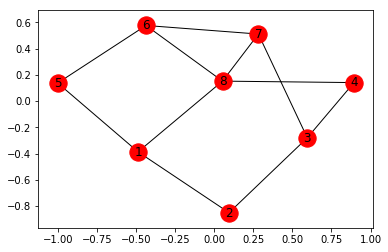

In [19]:
G8 = {1:{2,5,8}, 2:{1,3}, 3:{2,4,7}, 4: {3,8}, 5:{1,6}, 6:{5,7,8}, 7:{3,6,8}, 8:{1,4,6,7}}
draw_graph(G8)

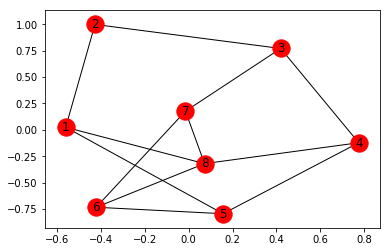

In [20]:
G9 = {1:{2,5,8}, 2:{1,3}, 3:{2,4,7}, 4:{3,5,8}, 5:{1,4,6}, 6:{5,7,8}, 7:{3,6,8}, 8:{1,4,6,7}}
draw_graph(G9)

In [21]:
def run_lps(G):
    clique_opt, clique_x, clique_x_map = lp_clique(G)
    print('optimal fractional clique cover number', clique_opt, '\n solution vector', clique_x, '\n solution vector mapped to the subsets', clique_x_map)
    entropy_opt, entropy_x, entropy_x_map = lp_entropy(G)
    print('optimal shannon entropy', entropy_opt, '\n solution vector', entropy_x, '\n solution vector mapped to the subsets', entropy_x_map)
    return clique_opt + entropy_opt >= len(G)

In [22]:
run_lps(G8)

optimal fractional clique cover number 4 
 solution vector [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] 
 solution vector mapped to the subsets {(1,): 0, (1, 2): 0, (1, 5): 1, (1, 8): 0, (2,): 1, (2, 3): 0, (3,): 0, (3, 4): 1, (3, 7): 0, (4,): 0, (4, 8): 0, (5,): 0, (5, 6): 0, (6,): 0, (6, 7): 0, (6, 7, 8): 1, (6, 8): 0, (7,): 0, (7, 8): 0, (8,): 0}
optimal shannon entropy 4 
 solution vector [1, 2, 2, 2, 2, 3, 4, 4, 4, 3, 4, 3, 3, 4, 4, 4, 3, 4, 3, 2, 3, 4, 4, 4, 3, 4, 3, 3, 4, 4, 4, 3, 4, 3, 2, 2, 3, 4, 4, 4, 3, 4, 3, 3, 4, 4, 4, 3, 4, 3, 2, 3, 4, 4, 4, 3, 4, 3, 3, 4, 4, 4, 3, 4, 3, 2, 2, 2, 3, 4, 4, 4, 3, 4, 3, 3, 4, 4, 4, 3, 4, 3, 2, 3, 4, 4, 4, 3, 4, 3, 3, 4, 4, 4, 3, 4, 3, 1, 1, 2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3, 2, 1, 2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3, 2, 1, 1, 1, 2, 3, 4, 4, 4, 3, 4, 3, 2, 3, 3, 3, 2, 3, 2, 2, 3, 4, 4, 4, 3, 4, 3, 2, 3, 3, 3, 2, 3, 2, 1, 2, 3, 4, 4, 4, 3, 4, 3, 2, 3, 3, 3, 2, 3, 2, 2, 3, 4, 4, 4, 3, 4, 3, 2, 3, 3, 3, 2, 3, 2, 1, 1, 2, 3,

True

In [23]:
run_lps(G9)

optimal fractional clique cover number 7/2 
 solution vector [0, 1/2, 1/2, 0, 0, 1/2, 0, 1/2, 0, 0, 1/2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] 
 solution vector mapped to the subsets {(1,): 0, (1, 2): 1/2, (1, 5): 1/2, (1, 8): 0, (2,): 0, (2, 3): 1/2, (3,): 0, (3, 4): 1/2, (3, 7): 0, (4,): 0, (4, 5): 1/2, (4, 8): 0, (5,): 0, (5, 6): 0, (6,): 0, (6, 7): 0, (6, 7, 8): 1, (6, 8): 0, (7,): 0, (7, 8): 0, (8,): 0}
optimal shannon entropy 9/2 
 solution vector [1, 3/2, 2, 5/2, 5/2, 7/2, 9/2, 9/2, 9/2, 7/2, 9/2, 7/2, 7/2, 9/2, 9/2, 9/2, 7/2, 9/2, 7/2, 5/2, 7/2, 9/2, 9/2, 9/2, 7/2, 9/2, 7/2, 3, 4, 4, 4, 3, 4, 3, 5/2, 5/2, 7/2, 9/2, 9/2, 9/2, 7/2, 9/2, 7/2, 7/2, 9/2, 9/2, 9/2, 7/2, 9/2, 7/2, 2, 3, 4, 4, 4, 3, 4, 3, 5/2, 7/2, 7/2, 7/2, 5/2, 7/2, 5/2, 2, 5/2, 5/2, 7/2, 9/2, 9/2, 9/2, 7/2, 9/2, 7/2, 7/2, 9/2, 9/2, 9/2, 7/2, 9/2, 7/2, 5/2, 7/2, 9/2, 9/2, 9/2, 7/2, 9/2, 7/2, 3, 4, 4, 4, 3, 4, 3, 2, 2, 3, 4, 4, 4, 3, 4, 3, 3, 4, 4, 4, 3, 4, 3, 3/2, 5/2, 7/2, 7/2, 7/2, 5/2, 7/2, 5/2, 2, 3, 3, 3, 2, 3, 2, 1, 3/

True